In [15]:
from unity_dataset import UnityDataset

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.manual_seed(0)

NUM_EPOCHS = 5

LEARNING_RATE = 1e-3
BATCH_SIZE = 2

IMG_SIZE = (480, 360)
PATCH_SIZE = (24, 40)

TRAIN_SET_PERCENT = 0.8
TEST_SET_LENGTH = 1

INPUT_IMAGE_DIR = "/media/blooker/Storage/gold-project-2021-images/480p-refactor-office-x4"

OUTPUT_IMAGE_DIR = "data/Data/Img"

transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
dataset = UnityDataset(root_dir=INPUT_IMAGE_DIR,
                       lit_folder='2',
                       unlit_folder='1',
                       depth_folder='0',
                       csv_file='0.csv',
                       img_size=IMG_SIZE,
                       patch_size=PATCH_SIZE,
                       transform=transform)

In [5]:
dataset_len = len(dataset)

train_set_length = int((dataset_len - TEST_SET_LENGTH) * TRAIN_SET_PERCENT)
val_set_length = (dataset_len - TEST_SET_LENGTH) - train_set_length

lengths = [train_set_length, val_set_length, TEST_SET_LENGTH]

In [6]:
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
def make_dir():
    if not os.path.exists(OUTPUT_IMAGE_DIR):
        os.makedirs(OUTPUT_IMAGE_DIR)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # params encoder
        self.enc_params1 = nn.Linear(3, 160)
        self.enc_params2 = nn.Linear(160, 420)
        self.enc_params3 = nn.Linear(420, 1350)

        # patch encoder
        self.enc_patch1 = nn.Linear(1, 25)
        self.enc_patch2 = nn.Linear(25, 60)
        self.enc_patch3 = nn.Linear(60, 90)

        # params_patch encoder
        self.enc_params_patch1 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=1)
        self.enc_params_patch2 = nn.Conv2d(in_channels=6, out_channels=22, kernel_size=3, padding=1)
        self.enc_params_patch3 = nn.Conv2d(in_channels=22, out_channels=38, kernel_size=3, padding=1)
        self.enc_params_patch4 = nn.Conv2d(in_channels=38, out_channels=70, kernel_size=3, padding=1)

        # lit encoder
        self.enc_lit1 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=1)
        self.enc_lit2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)

        # decoder
        self.dec1 = nn.Conv2d(in_channels=78, out_channels=78, kernel_size=1)

        self.dec2 = nn.Conv2d(in_channels=78, out_channels=86, kernel_size=3, padding=1)
        self.dec3 = nn.Conv2d(in_channels=86, out_channels=102, kernel_size=3, padding=1)
        self.dec4 = nn.Conv2d(in_channels=102, out_channels=118, kernel_size=3, padding=1)
        self.dec5 = nn.Conv2d(in_channels=118, out_channels=126, kernel_size=3, padding=1)

        self.dec6 = nn.ConvTranspose2d(in_channels=126, out_channels=126, kernel_size=2, stride=2)

        self.dec7 = nn.Conv2d(in_channels=126, out_channels=150, kernel_size=3, padding=1)
        self.dec8 = nn.Conv2d(in_channels=150, out_channels=166, kernel_size=3, padding=1)
        self.dec9 = nn.Conv2d(in_channels=166, out_channels=182, kernel_size=3, padding=1)

        self.dec10 = nn.Conv2d(in_channels=182, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x_unlit, x_dep, x_params, x_patch):
        # enc_params
        x_params = F.relu(self.enc_params1(x_params))   # (b, 160)
        x_params = F.relu(self.enc_params2(x_params))   # (b, 420)
        x_params = F.relu(self.enc_params3(x_params))   # (b, 1350)

        # enc_patch
        x_patch = F.relu(self.enc_patch1(x_patch))  # (b, 25)
        x_patch = F.relu(self.enc_patch2(x_patch))  # (b, 60)
        x_patch = F.relu(self.enc_patch3(x_patch))  # (b, 90)

        # Concatenate x_params and x_patch together
        x_params_patch = torch.cat((x_params, x_patch), dim=1)  # (b, 1440)
        x_params_patch = x_params_patch.reshape(-1, 6, 20, 12)      # (b, 8, 15, 12)

        # enc_params_patch
        x_params_patch = F.relu(self.enc_params_patch1(x_params_patch)) # (b, 6, 15, 12)
        x_params_patch = F.relu(self.enc_params_patch2(x_params_patch)) # (b, 22, 15, 12)
        x_params_patch = F.relu(self.enc_params_patch3(x_params_patch)) # (b, 38, 15, 12)
        x_params_patch = F.relu(self.enc_params_patch4(x_params_patch)) # (b, 70, 15, 12)

        # Concatenate x_unlit and x_dep to form x_lit
        x_lit = torch.cat((x_unlit, x_dep), 1)  # (b, 4, 30, 24)

        # lit encoder
        x_lit = F.relu(self.enc_lit1(x_lit))                    # (b, 4, 30, 24)
        x_lit = F.relu(self.enc_lit2(x_lit))                    # (b, 8, 30, 24)
        x_lit = F.max_pool2d(x_lit, kernel_size=2, stride=2)    # (b, 8, 15, 12)

        # Concatenate x_lit and x_params_patch
        x_lit = torch.cat((x_lit, x_params_patch), 1)  # (b, 78, 15, 12)

        # decoder
        x_lit = F.relu(self.dec1(x_lit))        # (b, 78, 15, 12)
        x_lit = F.relu(self.dec2(x_lit))        # (b, 86, 15, 12)
        x_lit = F.relu(self.dec3(x_lit))        # (b, 102, 15, 12)
        x_lit = F.relu(self.dec4(x_lit))        # (b, 118, 15, 12)
        x_lit = F.relu(self.dec5(x_lit))        # (b, 126, 15, 12)

        x_lit = F.relu(self.dec6(x_lit))        # (b, 126, 30, 24)

        x_lit = F.relu(self.dec7(x_lit))        # (b, 150, 30, 24)
        x_lit = F.relu(self.dec8(x_lit))        # (b, 166, 30, 24)
        x_lit = F.relu(self.dec9(x_lit))        # (b, 182, 30, 24)

        x_lit = torch.sigmoid(self.dec10(x_lit)) # (b, 3, 30, 24)

        return x_lit


net = Autoencoder()

In [9]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE)

In [10]:
def train(net, trainloader, validloader, NUM_EPOCHS):
    train_loss = []
    valid_loss = []

    device = get_device()
    for epoch in range(NUM_EPOCHS):
        start_time = time.perf_counter()
        running_loss = 0.0

        for phase in ["train", "val"]:

            training = phase == "train"

            net.train(training)
            if training:
                loader = trainloader
            else:
                loader = validloader

            for data in loader:
                x, x_dep, x_params, x_patch, y = data

                x = x.to(device, dtype=torch.float)
                x_dep = x_dep.to(device, dtype=torch.float)
                x_params = x_params.to(device, dtype=torch.float)
                x_patch = x_patch.to(device, dtype=torch.float)

                y = y.to(device, dtype=torch.float)

                for sample in range(x.shape[0]):
                    optimizer.zero_grad()
                    outputs = net(x[sample], x_dep[sample], x_params[sample], x_patch[sample])
                    loss = criterion(outputs, y[sample])

                    if training:
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()

            loss = running_loss / len(loader)

            if training:
                train_loss.append(loss)
            else:
                valid_loss.append(loss)

            print("Epoch {} of {}, {} loss: {:.6f}, Time: {:.4f}".format(
                epoch+1, NUM_EPOCHS, phase, loss, time.perf_counter()-start_time
            ))

        print()

    return train_loss, valid_loss

In [11]:
device = get_device()
print(device)

net = nn.DataParallel(net)
net.to(device)

cuda


DataParallel(
  (module): Autoencoder(
    (enc_params1): Linear(in_features=3, out_features=160, bias=True)
    (enc_params2): Linear(in_features=160, out_features=420, bias=True)
    (enc_params3): Linear(in_features=420, out_features=1350, bias=True)
    (enc_patch1): Linear(in_features=1, out_features=25, bias=True)
    (enc_patch2): Linear(in_features=25, out_features=60, bias=True)
    (enc_patch3): Linear(in_features=60, out_features=90, bias=True)
    (enc_params_patch1): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
    (enc_params_patch2): Conv2d(6, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_params_patch3): Conv2d(22, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_params_patch4): Conv2d(38, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_lit1): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    (enc_lit2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dec1): Conv2d(78, 78, kernel_size=(1, 1), stri

In [12]:
make_dir()

train_loss, valid_loss = train(net, train_loader, valid_loader, NUM_EPOCHS)

Epoch 1 of 5, train loss: 0.194148, Time: 2.4726
Epoch 1 of 5, val loss: 0.883588, Time: 2.6570

Epoch 2 of 5, train loss: 0.131036, Time: 1.2366
Epoch 2 of 5, val loss: 0.619791, Time: 1.4140

Epoch 3 of 5, train loss: 0.081911, Time: 1.2290
Epoch 3 of 5, val loss: 0.421500, Time: 1.3984

Epoch 4 of 5, train loss: 0.083621, Time: 1.2412
Epoch 4 of 5, val loss: 0.429595, Time: 1.4123

Epoch 5 of 5, train loss: 0.081610, Time: 1.1861
Epoch 5 of 5, val loss: 0.420153, Time: 1.3568



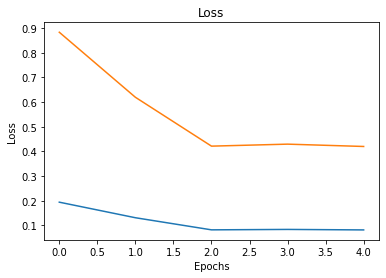

In [13]:
plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./" + OUTPUT_IMAGE_DIR + "/deep_ae_loss.png")

In [14]:
# Input to the model
x = torch.randn(1, 3, PATCH_SIZE[1], PATCH_SIZE[0])
x_dep = torch.randn(1, 1, PATCH_SIZE[1], PATCH_SIZE[0])
x_params = torch.randn(1, 3)
x_patch = torch.randn(1, 1)

# Move the model from GPU to CPU before exporting
net.cpu()

# Export the model
torch.onnx.export(net.module,                           # model being run
                  (x, x_dep, x_params, x_patch),        # model input (or a tuple for multiple inputs)
                  "./data/Data/model.onnx",             # where to save the model (can be a file or file-like object)
                  export_params=True,                   # store the trained parameter weights inside the model file
                  opset_version=9,                      # the ONNX version to export the model to
                  do_constant_folding=True,             # whether to execute constant folding for optimization
                  input_names = ['x_unlit',
                                 'x_dep',
                                 'x_params',
                                 'x_patch'],            # the model's input names
                  output_names = ['y']                  # the model's output name
                  )
